Epoch 1/300


/var/folders/0z/d22cxjf5413996fwwtvz8s2c0000gn/T/ipykernel_73872/2870604594.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['CallDateTime'].dt.floor('H')
/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8349 - root_mean_squared_error: 1.3147 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3077
Epoch 2/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.2048 - root_mean_squared_error: 0.4520 - val_loss: 0.1124 - val_root_mean_squared_error: 0.3352
Epoch 3/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.1332 - root_mean_squared_error: 0.3649 - val_loss: 0.0881 - val_root_mean_squared_error: 0.2968
Epoch 4/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.1062 - root_mean_squared_error: 0.3258 - val_loss: 0.0716 - val_root_mean_squared_error: 0.2676
Epoch 5/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.0859 - root_mean_squared_error: 0.2930 - val_loss: 0.0628 - val_root_mean_squared_error: 0.2505
Epoch 6/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0749 - root_mean_squared_error: 0.2737 - val_loss: 0.0598 - val_root_mean_squared_error: 0.2446
Epoch 7/300
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 898u

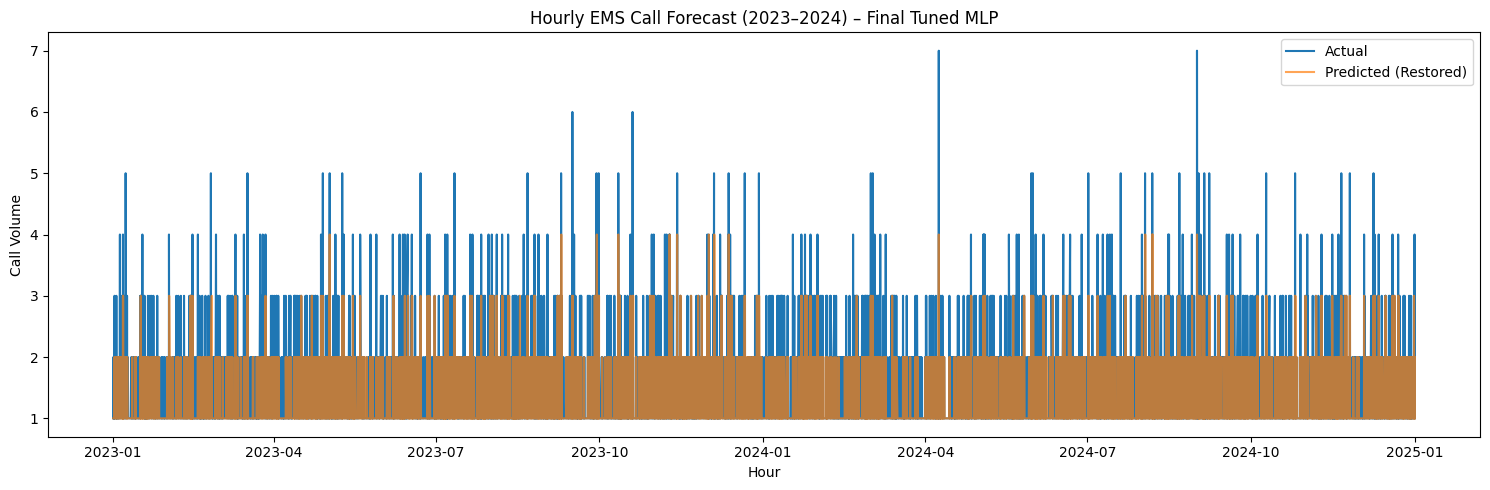

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Load EMS Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['hour'] = df['CallDateTime'].dt.floor('H')

# --- 2. Aggregate by hour ---
hourly = df.groupby('hour').size().reset_index(name='call_volume')

# --- 3. Time-based features ---
hourly['hour_of_day'] = hourly['hour'].dt.hour
hourly['day_of_week'] = hourly['hour'].dt.dayofweek
hourly['week_of_year'] = hourly['hour'].dt.isocalendar().week.astype(int)
hourly['month'] = hourly['hour'].dt.month
hourly['year'] = hourly['hour'].dt.year
hourly['day_of_year'] = hourly['hour'].dt.dayofyear
hourly['sin_doy'] = np.sin(2 * np.pi * hourly['day_of_year'] / 365.25)
hourly['cos_doy'] = np.cos(2 * np.pi * hourly['day_of_year'] / 365.25)
hourly['sin_hour'] = np.sin(2 * np.pi * hourly['hour_of_day'] / 24)
hourly['cos_hour'] = np.cos(2 * np.pi * hourly['hour_of_day'] / 24)
hourly['is_weekend'] = hourly['day_of_week'].isin([5, 6]).astype(int)

# --- 4. Lag + rolling features ---
for lag in [1, 24, 48, 168]:  # 1h, 1d, 2d, 1w
    hourly[f'lag_{lag}'] = hourly['call_volume'].shift(lag)

hourly['rolling_3h'] = hourly['call_volume'].rolling(3).mean()
hourly['rolling_24h'] = hourly['call_volume'].rolling(24).mean()
hourly['rolling_7d'] = hourly['call_volume'].rolling(24*7).mean()
hourly['trend_24h'] = hourly['rolling_3h'] - hourly['rolling_24h']

# --- 5. Drop NA rows ---
hourly.dropna(inplace=True)

# --- 6. Features ---
features = [
    'hour_of_day', 'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_24', 'lag_48', 'lag_168',
    'rolling_3h', 'rolling_24h', 'rolling_7d', 'trend_24h',
    'is_weekend', 'sin_doy', 'cos_doy', 'sin_hour', 'cos_hour'
]

X = hourly[features]
y = hourly['call_volume']

# --- 7. Train/Test Split ---
split_time = '2023-01-01'
train = hourly[hourly['hour'] < split_time]
test = hourly[hourly['hour'] >= split_time]
X_train = train[features]
X_test = test[features]
y_train = train['call_volume']
y_test = test['call_volume']

# --- 8. Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 9. Transform target ---
y_train_log = np.log1p(y_train)
y_test_actual = y_test.round().astype(int)

# --- 10. Build model ---
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# --- 11. Predict and evaluate ---
preds_log = model.predict(X_test_scaled).flatten()
preds = np.expm1(preds_log).round().astype(int)
preds = np.clip(preds, 0, None)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"🔥 Restored Hourly RMSE (log1p + mse): {rmse:.2f}")

# --- 12. Plot ---
plt.figure(figsize=(15, 5))
plt.plot(test['hour'].values, y_test_actual.values, label='Actual')
plt.plot(test['hour'].values, preds, label='Predicted (Restored)', alpha=0.7)
plt.legend()
plt.title('Hourly EMS Call Forecast (2023–2024) – Final Tuned MLP')
plt.xlabel('Hour')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()
